# Overview

Solve color transformation between a given filter and panstarrs.

$$ m_{X} = PSr   + C0 (PSg-PSr) $$

In [1]:
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
from astropy.table import Column
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting

import os
import numpy as np
from matplotlib import pyplot as plt

import speclite
from speclite import filters

import glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
homedir = os.getenv("HOME")

# Speclite Example

In [3]:
from speclite import filters

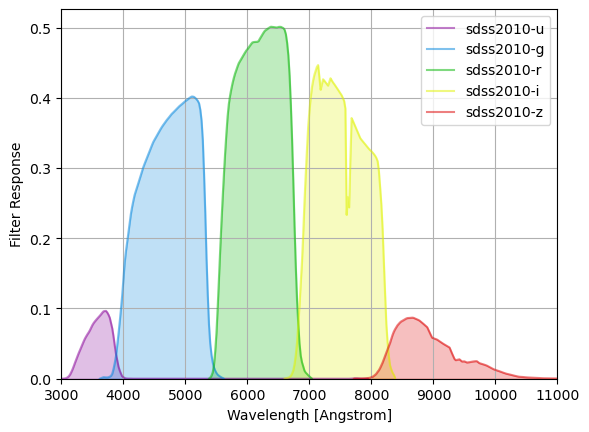

In [4]:
sdss = filters.load_filters('sdss2010-*')
filters.plot_filters(sdss, wavelength_limits=(3000, 11000))

# Creating New Filter Sets

In [5]:
filterpath = os.path.join(homedir,'research/Halpha_filters/fits_versions')

In [6]:
# Bok
fgroups = ['BOK90prime','MOS','HDI','WFC','panstarrs']

In [7]:
outdir = "/Users/rfinn/research/Halpha_filters/speclite_version"
for fg in fgroups:
    flist = glob.glob(os.path.join(filterpath,f"{fg}-*.fits"))
    filter_group = []
    for fname in flist:
        t1 = os.path.basename(fname).split('.fits')[0]
        #print(t1)
        t2 = t1.split(fg)[1]
        print(t2)
        filter_name = fname.split('.fits')[0].split(fg)[0]
        filter_name = t2[1:]
        print(fg, filter_name)
        this_filter = f"{fg}-{filter_name}"
        dat = fits.getdata(fname)

        # check if response is negative
        if np.any(dat['transmission'] < 0):
            print("\tWAIT")
            flag = dat['transmission'] < 0
            print(dat['wavelength'][flag])
        #sorted_indices = np.argsort(dat['wavelength'])
        #dat = dat[sorted_indices]
        bandname = filter_name.replace('+','').replace('-','')
        print("bandname = ", bandname)
        filter_response = filters.FilterResponse(wavelength = dat['wavelength']*u.Angstrom,\
                                                response=dat['transmission'],\
                                                meta = dict(group_name=fg, band_name=bandname))
        
        fr_name = filter_response.save(outdir)
os.system(f"cp {outdir}/*.ecsv /Users/rfinn/anaconda3/envs/filtertrans/lib/python3.10/site-packages/speclite/data/filters/.")

-BASSr
BOK90prime BASSr
bandname =  BASSr
-Ha+4nm
BOK90prime Ha+4nm
bandname =  Ha4nm
-Ha+4nm
MOS Ha+4nm
bandname =  Ha4nm
-Ha+8nm
MOS Ha+8nm
bandname =  Ha8nm
-Ha+12nm
MOS Ha+12nm
bandname =  Ha12nm
-Ha+16nm
MOS Ha+16nm
bandname =  Ha16nm
-HarrisR
MOS HarrisR
bandname =  HarrisR
-SDSSr
MOS SDSSr
bandname =  SDSSr
-Ha+12nm
HDI Ha+12nm
bandname =  Ha12nm
-Ha+16nm
HDI Ha+16nm
bandname =  Ha16nm
-SDSSr
HDI SDSSr
bandname =  SDSSr
-Ha
HDI Ha
bandname =  Ha
-HarrisR
HDI HarrisR
bandname =  HarrisR
-Ha+4nm
HDI Ha+4nm
bandname =  Ha4nm
-Ha+8nm
HDI Ha+8nm
bandname =  Ha8nm
-SDSSr-214
WFC SDSSr-214
bandname =  SDSSr214
-Ha-197
WFC Ha-197
bandname =  Ha197
-Ha-227
WFC Ha-227
bandname =  Ha227
-r
panstarrs r
bandname =  r
-g
panstarrs g
bandname =  g


0

In [8]:
for fg in fgroups:
    filters.filter_group_names.append(fg)


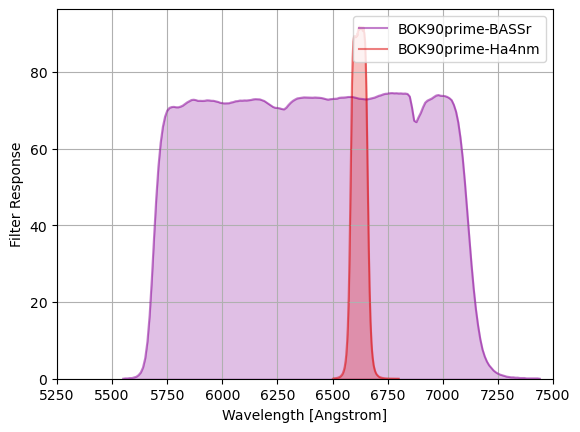

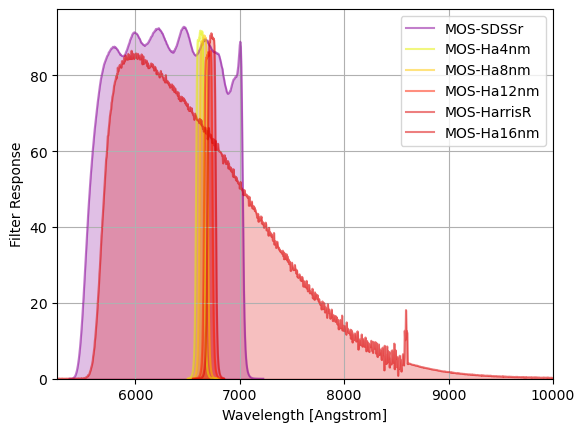

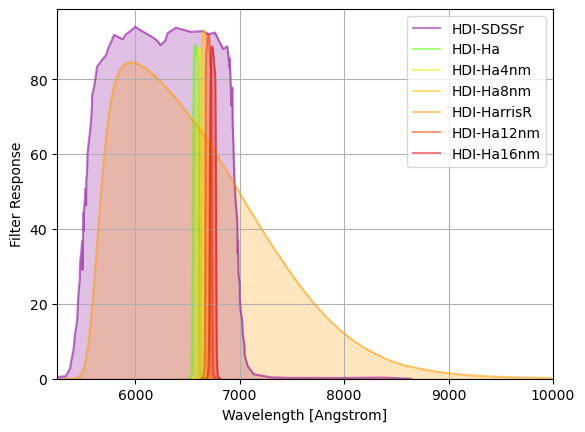

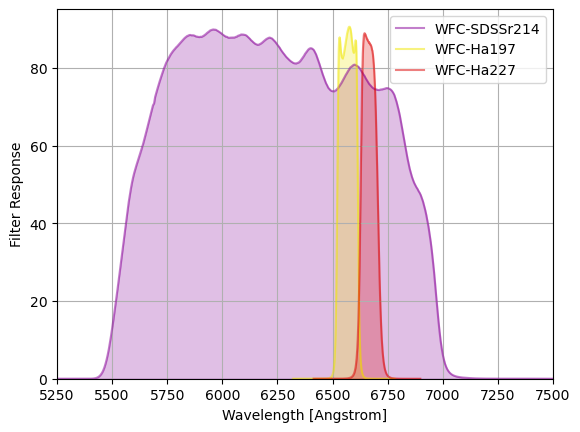

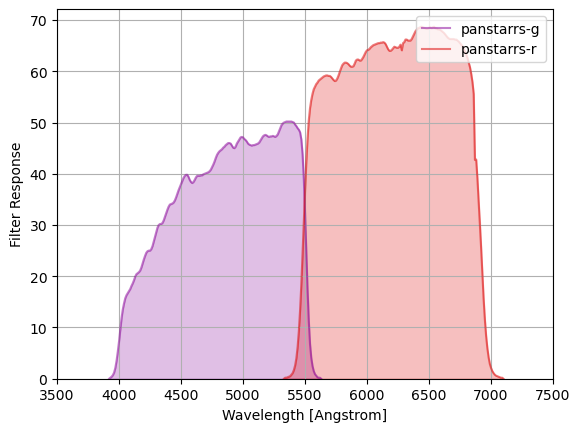

In [9]:
my_filter_lists = []
for fg in fgroups:

    t = filters.load_filters(f'{fg}-*')
    if 'panstarrs' in fg:
        xmin, xmax = 3500, 7500
    elif ('HDI' in fg) | ('MOS' in fg):
        xmin, xmax = 5250, 10000
    else:
        xmin, xmax = 5250, 7500
    filters.plot_filters(t, wavelength_limits=(xmin, xmax))
    my_filter_lists.append(t)

# Stellar Spectra

## MILES didn't work
* Downloaded MILES spectra, but they don't extend redward enough.


  


In [19]:
specpath = os.path.join(homedir,'research/Halpha_filters/stellar_libraries/fits')
specpatha = os.path.join(homedir,'research/Halpha_filters/stellar_libraries/ascii')

In [20]:
s1 = fits.getdata(os.path.join(specpath,"s0491.fits"))

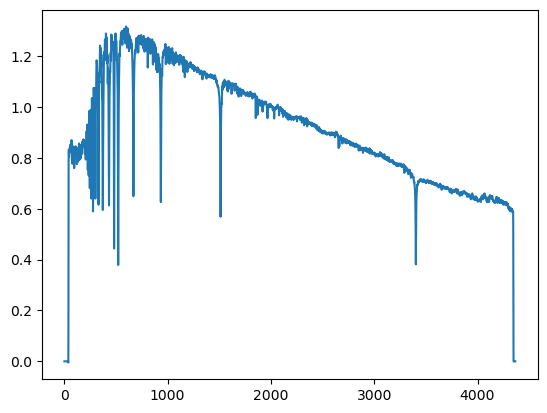

In [21]:
plt.plot(s1[0][:])

In [22]:
names = ['Wavelength','Flux']
a1 = Table.read(os.path.join(specpatha,"s0491"),format='csv', delimiter=' ',data_start=0,names=names)

In [23]:
a1

Wavelength,Flux
float64,float64
3500.0,0.0
3500.9,0.0
3501.8,0.0
3502.7,0.0
3503.6,0.0
3504.5,0.0
3505.4,0.0
3506.3,0.0
3507.2,0.0


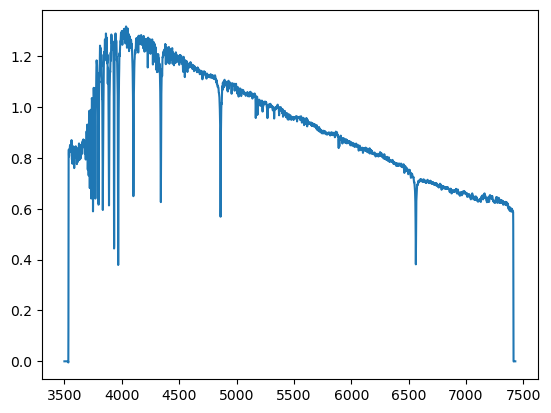

In [24]:
plt.plot(a1['Wavelength'],a1['Flux'])

In [40]:
wavelength = a1['Wavelength'] * u.Angstrom
flux = a1['Flux']

# The X-shooter Spectral Library 

* Got Allstars The X-shooter Spectral Library
 (xsl) spectra at http://xsl.u-strasbg.fr/page_dr3_all.html
```
The XSL DR3 spectra were released on March 1st 2022. DR3 contains 830 stellar spectra of 683 stars. The DR3 spectra are arm-combined to the full wavelength range of the X-shooter spectrograph, and both original and galactic dust extinction corrected spectra are available. The spectra are provided as FITS binary tables, each containing four or three columns. See Verro et al. (2022a) for more details.
```
* from http://svocats.cab.inta-csic.es/xshooter/index.php
```
The X-Shooter Spectral Library is a collection of 3000-25000 Å all stellar spectra observed at a resolving power of R = λ/Δλ ~ 10 000 with the medium-resolution spectrograph X-Shooter at the Very Large Telescope (VLT).
```
* description of the catalog: http://cdsarc.u-strasbg.fr/viz-bin/cat/J/A+A/660/A34#/description
  


In [45]:
s1

WAVE,FLUX,FLUX_DR,ERR
nm,erg / (Angstrom s cm2),erg / (Angstrom s cm2),erg / (Angstrom s cm2)
float32,float32,float32,float32
350.0,8.1834615e-13,9.475502e-13,6.807972e-14
350.0117,7.846802e-13,9.0856646e-13,6.689231e-14
350.02335,6.6857023e-13,7.7412284e-13,6.465247e-14
350.03503,5.3363124e-13,6.178783e-13,6.224023e-14
350.0467,5.8729085e-13,6.8000765e-13,6.279544e-14
350.05838,5.872081e-13,6.7990996e-13,6.223438e-14
350.07007,5.273187e-13,6.105642e-13,6.0626214e-14
350.08173,4.8333115e-13,5.5963106e-13,6.035491e-14


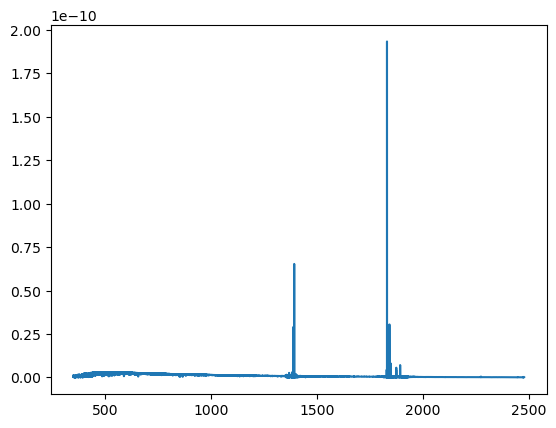

In [48]:
plt.plot(s1['WAVE'], s1['FLUX'])
#plt.gca().set_yscale("log")

# Combine Filters and Spectra!

Get magnitude through filters

In [10]:
# get spec files
specpath = os.path.join(homedir,'research/Halpha_filters/stellar_libraries/xsl_vlt/XSL_DR3_release/')
speclist = glob.glob(os.path.join(specpath,'*.fits'))

# create empty table to hold magnitudes
allfilters = []
for mf in my_filter_lists:
    for fname in mf.names:
        allfilters.append(fname)
print(allfilters)
magtab = Table(np.zeros([len(speclist),len(allfilters)],'d'), names=allfilters)

starnames = []
for i in range(len(speclist)):
    s1 = Table.read(speclist[i])
    starnames.append(os.path.basename(speclist[i]))
    for mf in my_filter_lists:
        #print(mf.names)
        mags = mf.get_ab_magnitudes(s1['FLUX'], s1['WAVE'])
        #formats = dict((n, '%.3f') for n in mf.names)
        for fname in mf.names:
            magtab[fname][i] = mags[fname][0]
    #if i > 10:
    #    break
#mags.write(None, format='ascii.fixed_width', formats=formats)

['BOK90prime-BASSr', 'BOK90prime-Ha4nm', 'MOS-SDSSr', 'MOS-Ha4nm', 'MOS-Ha8nm', 'MOS-Ha12nm', 'MOS-HarrisR', 'MOS-Ha16nm', 'HDI-SDSSr', 'HDI-Ha', 'HDI-Ha4nm', 'HDI-Ha8nm', 'HDI-HarrisR', 'HDI-Ha12nm', 'HDI-Ha16nm', 'WFC-SDSSr214', 'WFC-Ha197', 'WFC-Ha227', 'panstarrs-g', 'panstarrs-r']


In [11]:
magtab

BOK90prime-BASSr,BOK90prime-Ha4nm,MOS-SDSSr,MOS-Ha4nm,MOS-Ha8nm,MOS-Ha12nm,MOS-HarrisR,MOS-Ha16nm,HDI-SDSSr,HDI-Ha,HDI-Ha4nm,HDI-Ha8nm,HDI-HarrisR,HDI-Ha12nm,HDI-Ha16nm,WFC-SDSSr214,WFC-Ha197,WFC-Ha227,panstarrs-g,panstarrs-r
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7.571478071978138,7.51242803873267,7.602571606552408,7.51242803873267,7.499101954132497,7.4909572605631345,7.543817582538049,7.485127365405262,7.615075460708919,7.55449287756714,7.51262212965621,7.498634449372985,7.553427108366577,7.489612664224394,7.483784052689881,7.612896449994055,7.5415864472863685,7.4971476696916035,8.22134874895556,7.619394975135885
15.558217120161572,15.446414020021443,15.614413883201312,15.446414020021443,15.429997485725224,15.41495920583474,nan,15.402995436694425,15.636919188876458,15.485760897406337,15.446405860676936,15.428829810293607,nan,15.412906296154937,15.3996025489593,15.639568928918601,15.482667197370175,15.42606301697997,16.732740757541062,15.647752299224857
9.910803241704233,9.832060310015265,10.048387471837101,9.832060310015265,10.003746475020488,10.165182300562615,9.316947295122626,10.114032415552304,10.14117921908092,9.685994772646412,9.796668391668618,10.05849029774361,9.384172425783316,10.195831310710696,10.105996862376092,10.209589924669178,9.605239173886678,10.059396670063856,11.548923638425455,10.228721281355366
14.991983909579503,14.898692701057213,15.035609722855288,14.898692701057213,14.885643815035042,14.873934039160313,14.933946691430577,14.864626916043246,15.053045060053751,14.946080018309795,14.897718793316468,14.88464796718934,14.948478478273827,14.872860647055901,14.861880828009262,15.054802792535602,14.939749332892635,14.882527746171865,15.816424268345477,15.06100586743775
7.211808691166461,7.135826078080366,7.2448651217371305,7.135826078080366,7.134112879481744,7.131913695110891,7.17735990721178,7.124036188908161,7.258638332197162,7.157391090574144,7.133664607387531,7.135325180429505,7.187694296698199,7.132142755286691,7.121233062828503,7.256962500775929,7.159963123455183,7.133906913987103,7.854826901366115,7.263733735957429
9.321738993252403,9.223011549766108,9.363879191723973,9.223011549766108,9.216660461236284,9.215931230844095,9.269400556365914,9.211666428184229,9.38235115978326,9.25295347995961,9.222320813793223,9.2174160595666,9.283163371720228,9.216263312545605,9.210924255571651,9.379567781675398,9.246342823288847,9.216744202182273,10.247753436399618,9.388829148557479
9.010426850832978,9.07071631845224,8.992292820404549,9.07071631845224,9.038815649355598,9.039871202620036,9.033919743243997,9.045179977628406,8.985458874650966,9.247274991423794,9.056826679698295,9.034871363818766,9.027336765419081,9.039805472438017,9.047608376999557,8.98537161517407,9.195422818424916,9.036664147103306,8.815543209656294,8.983005824778113
17.120120269549414,16.950875693604864,17.234753261381538,16.950875693604864,17.105140974413857,17.270755609694806,16.69935600300118,17.252914741591503,17.306896528478642,16.849343971629423,16.91566149238006,17.152913053542886,16.753216976426664,17.295391794224088,17.25660087975161,17.355527287222184,16.822888955327855,17.158974303060294,18.734977594771774,17.368710995940408
6.70661154404843,6.754504966325229,6.690731878024863,6.754504966325229,6.72764022532448,6.730132888229927,6.726974215549562,6.735510282757227,6.685566388986205,6.91881282662221,6.741144723792809,6.725171461518679,6.721102289822563,6.730074350407968,6.7379073404524314,6.684745578724582,6.873720625728875,6.726470273432961,6.576863205949394,6.683435970793559


In [12]:
c1 = Column(starnames, name='starfile')

In [13]:
c1

xsl_spectrum_X0586_merged.fits
xsl_spectrum_X0419_merged.fits
xsl_spectrum_X0149_merged.fits
xsl_spectrum_X0706_merged_scl.fits
xsl_spectrum_X0300_merged.fits
xsl_spectrum_X0650_merged.fits
xsl_spectrum_X0732_merged.fits
xsl_spectrum_X0808_merged_ncl.fits
xsl_spectrum_X0469_merged.fits
xsl_spectrum_X0139_merged.fits
xsl_spectrum_X0513_merged_ncl.fits


In [14]:
magtab.add_column(c1)

In [15]:
numnan=0
for i,mrow in enumerate(magtab):
    for j in range(len(mrow)-1):
        if np.isnan(mrow[j]):
            print(i,j,magtab['starfile'][i])
            numnan += 1
            break

print(f"number with nans = {numnan}")

1 6 xsl_spectrum_X0419_merged.fits
25 0 xsl_spectrum_X0052_merged_ncl_ncge.fits
29 6 xsl_spectrum_X0075_merged.fits
34 6 xsl_spectrum_X0612_merged.fits
35 6 xsl_spectrum_X0340_merged_ncl_ncge.fits
40 6 xsl_spectrum_X0218_merged_ncl_ncge.fits
44 0 xsl_spectrum_X0606_merged_ncge.fits
47 6 xsl_spectrum_X0591_merged_ncl.fits
51 6 xsl_spectrum_X0301_merged_ncl_ncge.fits
66 6 xsl_spectrum_X0460_merged.fits
82 6 xsl_spectrum_X0336_merged_ncl_ncge.fits
86 6 xsl_spectrum_X0818_merged.fits
104 0 xsl_spectrum_X0131_merged_ncge.fits
109 6 xsl_spectrum_X0030_merged_ncl.fits
118 6 xsl_spectrum_X0036_merged_ncl_ncge.fits
119 0 xsl_spectrum_MD001_merged_ncl_ncge.fits
120 0 xsl_spectrum_X0353_merged_ncge.fits
127 6 xsl_spectrum_MD007_merged_scl.fits
143 18 xsl_spectrum_X0187_merged_ncl.fits
152 0 xsl_spectrum_X0029_merged_ncl.fits
157 6 xsl_spectrum_X0061_merged_ncl.fits
159 6 xsl_spectrum_X0070_merged.fits
167 0 xsl_spectrum_MD011_merged_scl.fits
187 18 xsl_spectrum_X0159_merged_ncl_ncge.fits
196 18 x

In [16]:
len(magtab)

830

In [17]:
magtab.colnames

['BOK90prime-BASSr',
 'BOK90prime-Ha4nm',
 'MOS-SDSSr',
 'MOS-Ha4nm',
 'MOS-Ha8nm',
 'MOS-Ha12nm',
 'MOS-HarrisR',
 'MOS-Ha16nm',
 'HDI-SDSSr',
 'HDI-Ha',
 'HDI-Ha4nm',
 'HDI-Ha8nm',
 'HDI-HarrisR',
 'HDI-Ha12nm',
 'HDI-Ha16nm',
 'WFC-SDSSr214',
 'WFC-Ha197',
 'WFC-Ha227',
 'panstarrs-g',
 'panstarrs-r',
 'starfile']

In [18]:
outlier_files = ['xsl_spectrum_X0301_merged_ncl_ncge.fits',
                 'xsl_spectrum_X0146_merged_ncl_ncge.fits',
                 'xsl_spectrum_X0184_merged_ncl.fits', 
                 'xsl_spectrum_X0226_merged_ncl_ncge.fits',
                 'xsl_spectrum_X0215_merged_ncl_ncge.fits']
discard_flag = (magtab['starfile'] == outlier_files[0])
for ofile in outlier_files[1:]:
    discard_flag = discard_flag | (magtab['starfile'] == ofile) 
magtab_cut = magtab[~discard_flag]

In [19]:
for cname in magtab_cut.colnames:
    print(cname, np.sum(np.isnan(magtab_cut[cname])))

BOK90prime-BASSr 34
BOK90prime-Ha4nm 1
MOS-SDSSr 34
MOS-Ha4nm 1
MOS-Ha8nm 0
MOS-Ha12nm 0
MOS-HarrisR 111
MOS-Ha16nm 0
HDI-SDSSr 34
HDI-Ha 1
HDI-Ha4nm 1
HDI-Ha8nm 1
HDI-HarrisR 111
HDI-Ha12nm 0
HDI-Ha16nm 0
WFC-SDSSr214 34
WFC-Ha197 1
WFC-Ha227 0
panstarrs-g 39
panstarrs-r 34


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

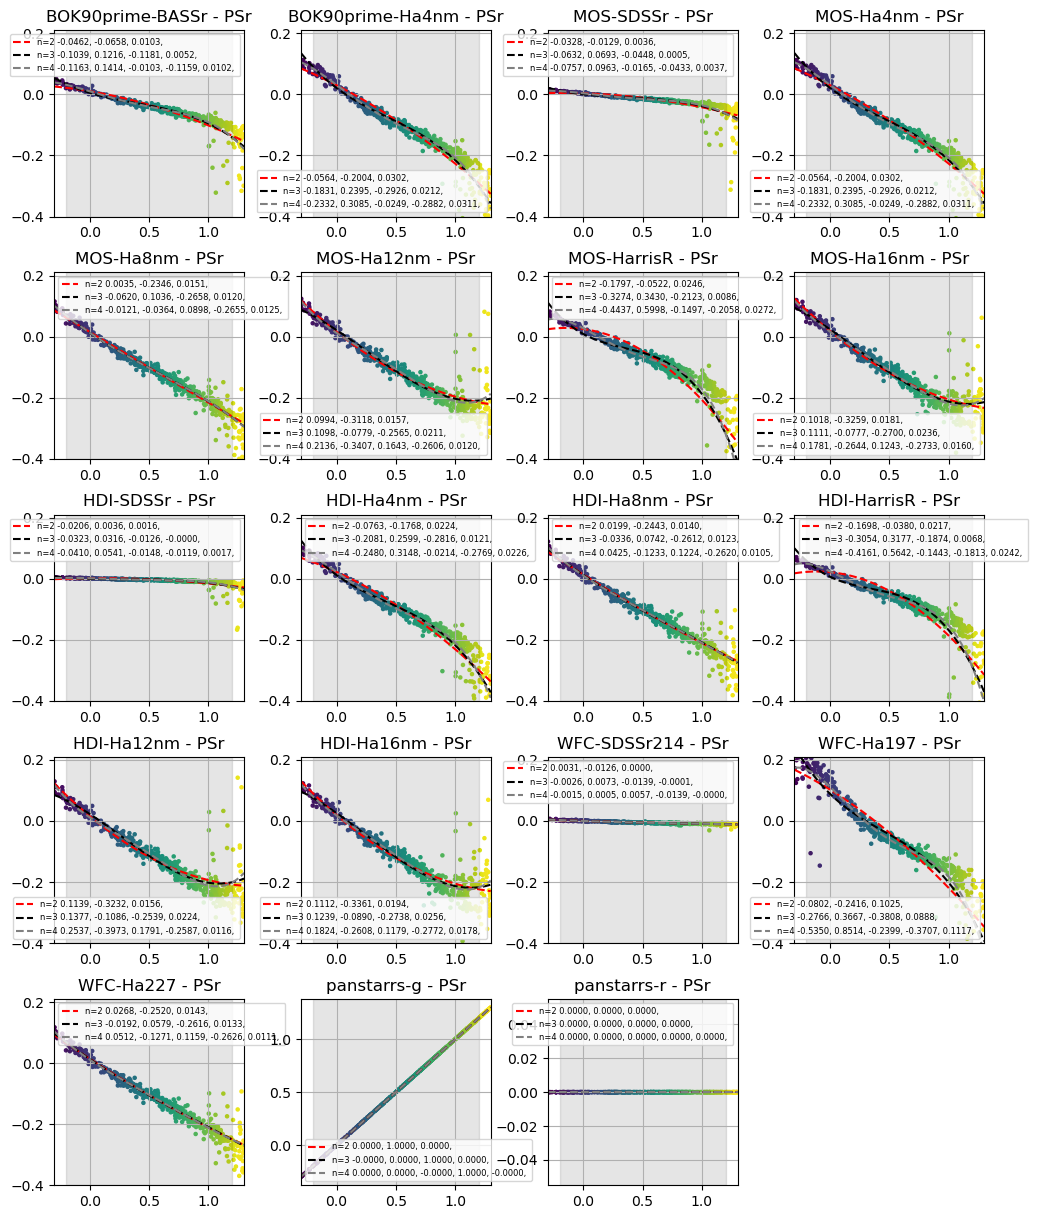

In [20]:
plt.figure(figsize=(12,15))
plt.subplots_adjust(hspace=0.3,wspace=0.3)
nplot = 1
xmin = -.3
xmax = 1.3
ymax = 0.21
ymin = -0.4
mycolor = magtab_cut['panstarrs-g'] - magtab_cut['panstarrs-r']
for cname in magtab.colnames[0:-1]:
    if cname == 'HDI-Ha':
        continue
    plt.subplot(5,4,nplot)
    dmag = magtab_cut[cname]-magtab_cut['panstarrs-r']

    # fit line
    fitflag = (mycolor < xmax) & (mycolor > xmin) & (~np.isnan(mycolor)) & (~np.isnan(dmag))
    
    plt.scatter(mycolor[fitflag], dmag[fitflag],c=mycolor[fitflag],s=5,vmin=xmin,vmax=xmax)
    plt.title(cname+' - PSr')


    # Identify Outliers
    #outlierflag = np.abs(dmag) > 1.
    #if np.sum(outlierflag) > 0:
    #    print(magtab_cut['starfile'][outlierflag])

    
    # fit line
    fitcolors = ['r','k','0.5']
    for npower in [2, 3, 4]:
        c = np.polyfit(mycolor[fitflag],dmag[fitflag],npower)

        comment = f"n={npower} "
        for i,cval in enumerate(c):
            comment += f"{cval:.4f}, "
        xline = np.linspace(xmin,xmax,100)
        plt.plot(xline,np.polyval(c,xline),'r--',color=fitcolors[npower-2],label=comment)
        #plt.text(0.02,0.05*2*npower,comment, transform=plt.gca().transAxes)
    #print(cname)
    y1, y2 = plt.ylim()
    


    nplot += 1
    plt.legend(fontsize=6)
    #plt.axhline(ls='-', color='k')
    if ('panstarrs' not in cname):
        plt.ylim(ymin,ymax)
    plt.xlim(xmin,xmax)
    plt.grid('True')
    plt.gca().axvspan(-0.2, 1.2, color='k', alpha=.1)


# Fit with sigma clipping

* this didn't work as well, so sticking with `np.polyfit`

In [21]:
def polyfit_sigma_clipping(x, y, degree=2, nsigma=3,niter=5):
    # 2. Initialize the polynomial model and fitter
    poly_init = models.Polynomial1D(degree) # Initialize a 2nd degree polynomial model

    #fitter = fitting.LinearLSQFitter() # Standard least squares fitter
    fitter = fitting.LevMarLSQFitter()
    
    # 3. Initialize the outlier removal fitter
    # This wraps the standard fitter with sigma clipping logic
    or_fit = fitting.FittingWithOutlierRemoval(
        fitter,
        sigma_clip,
        niter=niter,        # Number of iterations for sigma clipping
        sigma=nsigma       # Number of standard deviations to clip beyond
    )
    
    # 4. Fit the data
    # The fit returns the fitted model and a mask indicating clipped points
    fitted_poly, mask = or_fit(poly_init, x, y)
    
    return fitted_poly, mask

BOK90prime-BASSr
BOK90prime-Ha4nm
MOS-SDSSr
MOS-Ha4nm
MOS-Ha8nm
MOS-Ha12nm
MOS-HarrisR
MOS-Ha16nm
HDI-SDSSr
HDI-Ha
HDI-Ha4nm
HDI-Ha8nm
HDI-HarrisR
HDI-Ha12nm
HDI-Ha16nm
WFC-SDSSr214
WFC-Ha197
WFC-Ha227
panstarrs-g
panstarrs-r


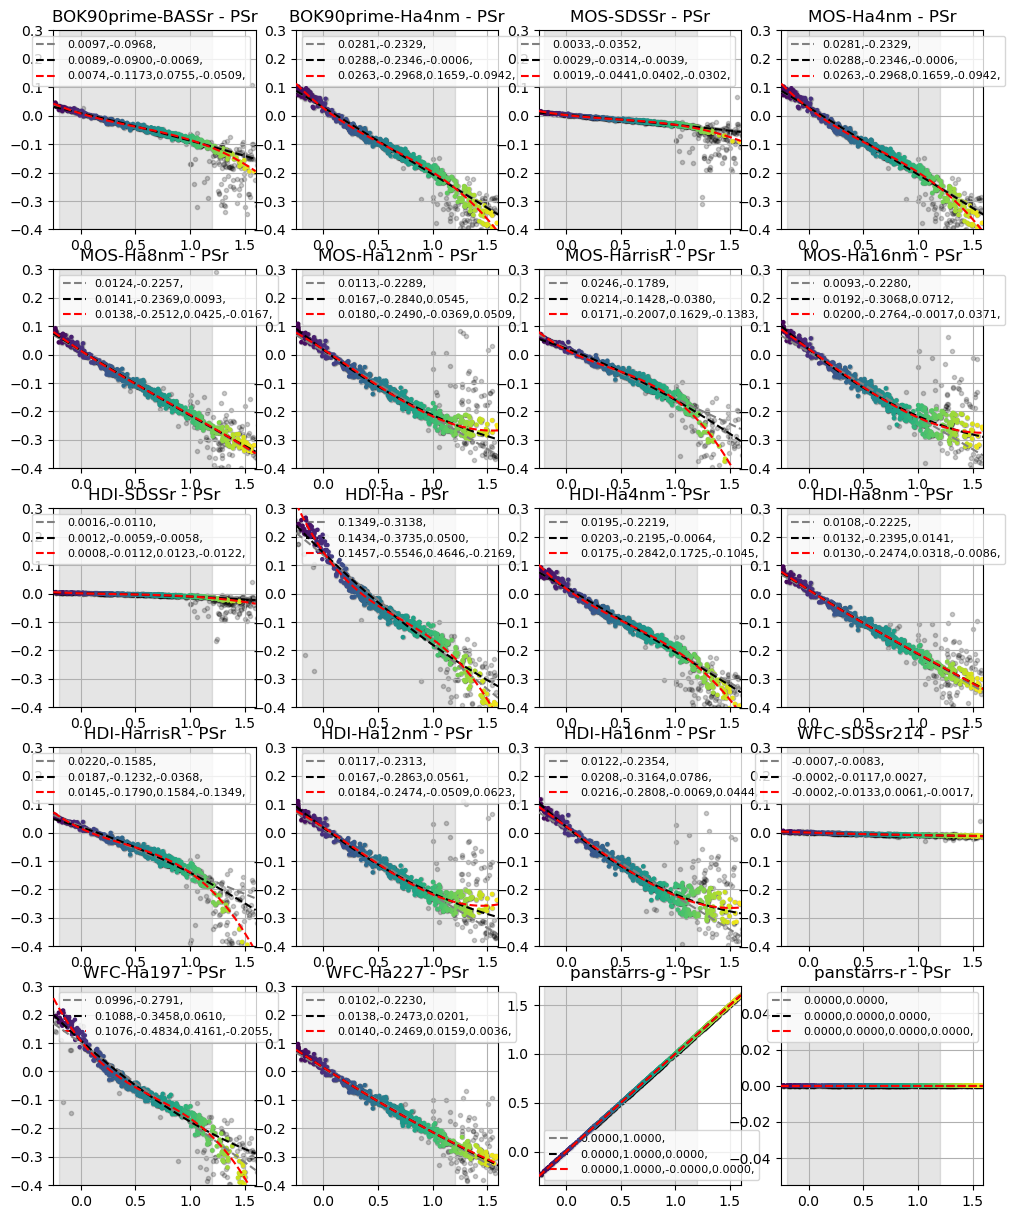

In [22]:
plt.figure(figsize=(12,15))
nplot = 1
nplot = 1
xmin = -.25
xmax = 1.6
ymax = 0.3
ymin = -0.4
mycolor = magtab_cut['panstarrs-g'] - magtab_cut['panstarrs-r']
for cname in magtab.colnames[0:-1]:
    print(cname)
    
    plt.subplot(5,4,nplot)
    dmag = magtab_cut[cname]-magtab_cut['panstarrs-r']

    # fit line
    fitflag = (mycolor < xmax) & (mycolor > xmin) & (~np.isnan(mycolor)) & (~np.isnan(dmag))
    
    
    # fit line
    fitcolors = ['0.5','k','r']
    for npower in [1, 2, 3]:
        fitted_poly, mask = polyfit_sigma_clipping(mycolor[fitflag],dmag[fitflag],degree=npower)
        #fitted_poly, mask = polyfit_sigma_clipping(mycolor,dmag,npower)
        xline = np.linspace(xmin,xmax,100)
        s = ""
        for i in fitted_poly.parameters:
            s += f"{i:.4f}," 
        plt.plot(xline,fitted_poly(xline),'r--',color=fitcolors[npower-1],zorder=15,label=s)
        comment = ""
        #for i,cval in enumerate(c):
        #    comment += f"{cval:.4f}, "
        #plt.text(0.02,0.05*2*npower,comment, transform=plt.gca().transAxes)
        #print(f"\t{fitted_poly.parameters}")
    
    plt.scatter(mycolor[fitflag][~mask], dmag[fitflag][~mask],c=mycolor[fitflag][~mask],s=5,vmin=xmin,vmax=xmax,zorder=10)
    plt.legend(fontsize=8)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    plt.plot(mycolor, dmag,'k.', alpha=0.2,zorder=1)
    plt.title(cname+' - PSr')
    plt.axis([x1,x2,y1,y2])
    #plt.axhline(ls='-', color='k')
    if ('panstarrs' not in cname):
        plt.ylim(ymin,ymax)
    plt.grid('True')
    plt.xlim(xmin,xmax)
    plt.gca().axvspan(-0.2, 1.2, color='k', alpha=.1)
    
    nplot += 1

# Manga MaStar Spectra

In [23]:
mastarfile = '/Users/rfinn/research/Halpha_filters/stellar_libraries/MaStar/mastar-goodspec-v2_4_3-v1_0_2.fits'
mhdu = fits.open(mastarfile)
mhdu[1].data.columns

ColDefs(
    name = 'DRPVER'; format = '6A'
    name = 'MPROCVER'; format = '6A'
    name = 'MANGAID'; format = '11A'
    name = 'PLATE'; format = 'J'
    name = 'IFUDESIGN'; format = '5A'
    name = 'MJD'; format = 'J'
    name = 'IFURA'; format = 'D'
    name = 'IFUDEC'; format = 'D'
    name = 'OBJRA'; format = 'D'
    name = 'OBJDEC'; format = 'D'
    name = 'PSFMAG'; format = '5E'
    name = 'MNGTARG2'; format = 'J'
    name = 'NEXP'; format = 'I'
    name = 'HELIOV'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'V_ERRCODE'; format = 'I'
    name = 'WAVE'; format = '4563D'
    name = 'FLUX'; format = '4563E'
    name = 'IVAR'; format = '4563E'
    name = 'DISP'; format = '4563E'
    name = 'PREDISP'; format = '4563E'
    name = 'MASK'; format = '4563J'
    name = 'MJDQUAL'; format = 'J'
)

In [31]:
len(mhdu[1].data)

8646

max wavelength = 10353.805444147549
max wavelength = 10353.805444147549
max wavelength = 10353.805444147549
max wavelength = 10353.805444147549
max wavelength = 10353.805444147549
max wavelength = 10353.805444147549
max wavelength = 10353.805444147549
max wavelength = 10353.805444147549
max wavelength = 10353.805444147549
max wavelength = 10353.805444147549


Text(0, 0.5, 'Flux ')

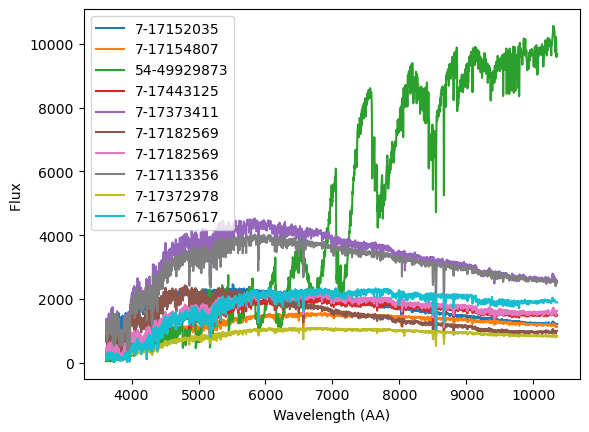

In [24]:
plt.figure()
for i in range(10):
    plt.plot(mhdu[1].data[i]['WAVE'],mhdu[1].data[i]['FLUX'],label=mhdu[1].data[i]['MANGAID'])
    print(f"max wavelength = {np.max(mhdu[1].data[i]['WAVE'])}")
plt.legend()
plt.xlabel("Wavelength (AA)")
plt.ylabel("Flux ")

In [25]:
allfilters

['BOK90prime-BASSr',
 'BOK90prime-Ha4nm',
 'MOS-SDSSr',
 'MOS-Ha4nm',
 'MOS-Ha8nm',
 'MOS-Ha12nm',
 'MOS-HarrisR',
 'MOS-Ha16nm',
 'HDI-SDSSr',
 'HDI-Ha',
 'HDI-Ha4nm',
 'HDI-Ha8nm',
 'HDI-HarrisR',
 'HDI-Ha12nm',
 'HDI-Ha16nm',
 'WFC-SDSSr214',
 'WFC-Ha197',
 'WFC-Ha227',
 'panstarrs-g',
 'panstarrs-r']

In [26]:
# get spec files
specpath = os.path.join(homedir,'research/Halpha_filters/stellar_libraries/MaStar/')
speclist = glob.glob(os.path.join(specpath,'*.fits'))
mastarfile = '/Users/rfinn/research/Halpha_filters/stellar_libraries/MaStar/mastar-goodspec-v2_4_3-v1_0_2.fits'
mhdu = fits.open(mastarfile)
speclist = mhdu[1].data
# create empty table to hold magnitudes

mastartab = Table(np.zeros([len(speclist),len(allfilters)],'d'), names=allfilters)

starnames = []
for i in range(len(speclist)):
    s1 = speclist[i]
    starnames.append(s1['MANGAID'])
    for mf in my_filter_lists:
        #print(mf.names)
        mags = mf.get_ab_magnitudes(s1['FLUX'], s1['WAVE'])
        #formats = dict((n, '%.3f') for n in mf.names)
        for fname in mf.names:
            mastartab[fname][i] = mags[fname][0]
    #if i > 10:
    #    break
#mags.write(None, format='ascii.fixed_width', formats=formats)

In [27]:
mastartab

BOK90prime-BASSr,BOK90prime-Ha4nm,MOS-SDSSr,MOS-Ha4nm,MOS-Ha8nm,MOS-Ha12nm,MOS-HarrisR,MOS-Ha16nm,HDI-SDSSr,HDI-Ha,HDI-Ha4nm,HDI-Ha8nm,HDI-HarrisR,HDI-Ha12nm,HDI-Ha16nm,WFC-SDSSr214,WFC-Ha197,WFC-Ha227,panstarrs-g,panstarrs-r
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-29.749209674240802,-29.801350698411984,-29.719736899701388,-29.801350698411984,-29.81585989049828,-29.826635374822178,-29.783086778195823,-29.834674050853238,-29.707304494370344,-29.747632263476113,-29.803467608605885,-29.815383392321692,-29.773550731321823,-29.82782872185593,-29.836829386782952,-29.708304771042897,-29.761230892905786,-29.818568603608966,-29.14254504755078,-29.702793305386457
-29.365412591276264,-29.458167049022542,-29.31456299958569,-29.458167049022542,-29.477499300157145,-29.49303111804467,-29.431707275446218,-29.500821317869036,-29.293882883711277,-29.413300832984916,-29.4587855275661,-29.478324660265628,-29.41481218676072,-29.495123416037732,-29.502096554247046,-29.293288178415153,-29.42386342733164,-29.481805759118622,-28.36898771346278,-29.284475945470394
-29.98696698241109,-30.11891219634151,-29.87754740336411,-30.11891219634151,-29.995618697638925,-29.85986363264841,-30.384454595145197,-29.857887230317846,-29.810361253974484,-30.205954710435012,-30.145283552131907,-29.9613545373642,-30.33310474737896,-29.84358472799024,-29.849650620354407,-29.768445906962388,-30.25638148447673,-29.952275783981335,-28.520511551749482,-29.75472572076059
-29.63846529262447,-29.729456052158838,-29.59071011447675,-29.729456052158838,-29.752869605484996,-29.76994152922044,-29.696880545678237,-29.77906174071655,-29.571601357289858,-29.676290032705836,-29.728883170776168,-29.7553037036444,-29.68119847768586,-29.771996204007426,-29.781130158138826,-29.571847800886935,-29.68725426529818,-29.758093224103433,-28.663194483476474,-29.56323471747496
-30.47414442014089,-30.541542039199445,-30.43897138583808,-30.541542039199445,-30.56000066781017,-30.56875817998222,-30.51249704192964,-30.577072181134067,-30.424266992354433,-30.48824410589722,-30.54292266486403,-30.55985492501685,-30.501063574179742,-30.56917520557556,-30.57927088206136,-30.426319783847777,-30.50263423379672,-30.562408071879883,-29.697865565537267,-30.41886978705196
-29.603731633380374,-29.637716385170563,-29.58492080865543,-29.637716385170563,-29.65017290163562,-29.65335970094801,-29.62013575790642,-29.656111634243704,-29.576328110963495,-29.59148381625817,-29.639059042390926,-29.64969846202765,-29.614100450868733,-29.654280782457718,-29.657193364995873,-29.580348417744542,-29.606009940531408,-29.65046278722182,-29.066069775261127,-29.57452065788391
-29.730658364330893,-29.817476544532177,-29.685517025607602,-29.817476544532177,-29.834217480061156,-29.846919595365293,-29.784454747717405,-29.858934837301028,-29.667404533512133,-29.769585118986384,-29.817811349823184,-29.833921439701324,-29.769546861464814,-29.84840382340947,-29.862723057204484,-29.66913077712487,-29.78085166598759,-29.837127729195704,-28.788570420353075,-29.660066006288247
-30.37204544990238,-30.441379599679156,-30.334181700402972,-30.441379599679156,-30.458667623437616,-30.469478466475106,-30.418678696736606,-30.476714560125487,-30.318689945691833,-30.393701922486024,-30.442900677471364,-30.4590616702852,-30.406116407105092,-30.47104971400007,-30.478327168184215,-30.319820792711244,-30.403686127223388,-30.46181507422274,-29.580603837511845,-30.312515649956712
-28.983651879183007,-29.072683491364412,-28.933767754063023,-29.072683491364412,-29.09582948149799,-29.11320064627176,-29.048915134282836,-29.123257559130963,-28.91360409183241,-29.02222815724471,-29.07280519075341,-29.09841092826833,-29.032313566186957,-29.115665704859218,-29.126068098710924,-28.9133709414069,-29.03250648888487,-29.101216578978505,-27.98455851762303,-28.90457416310104


In [28]:
mastartab.write('/Users/rfinn/research/Halpha_filters/stellar_libraries/MaStar/mstarmags.fits',format='fits',overwrite=True)

# TODO

* truncate the HDI-HarrisR filter at 10,000 A (it extends to 12000 A).
* then remake the fits files
* remake the speclite filter traces
* recalculate the mastar magnitudes
* 

'BOK90prime-BASSr': [0.0096,-0.1041,0.0130,]
'BOK90prime-Ha4nm': [0.0383,-0.2730,0.0463,]
'MOS-SDSSr': [0.0029,-0.0362,0.0032,]
'MOS-Ha4nm': [0.0383,-0.2730,0.0463,]
'MOS-Ha8nm': [0.0187,-0.2485,0.0245,]
'MOS-Ha12nm': [0.0181,-0.2710,0.0454,]
'MOS-HarrisR': [0.0205,-0.1611,-0.0111,]
'MOS-Ha16nm': [0.0202,-0.2992,0.0736,]
'HDI-SDSSr': [0.0012,-0.0082,-0.0022,]
'HDI-Ha': [0.1538,-0.4472,0.1448,]
'HDI-Ha4nm': [0.0286,-0.2551,0.0386,]
'HDI-Ha8nm': [0.0173,-0.2439,0.0204,]
'HDI-HarrisR': [0.0178,-0.1395,-0.0127,]
'HDI-Ha12nm': [0.0181,-0.2760,0.0515,]
'HDI-Ha16nm': [0.0210,-0.3085,0.0846,]
'WFC-SDSSr214': [0.0003,-0.0126,0.0030,]
'WFC-Ha197': [0.1129,-0.3820,0.1105,]
'WFC-Ha227': [0.0174,-0.2475,0.0214,]
'panstarrs-g': [0.0000,1.0000,-0.0000,]
'panstarrs-r': [0.0000,0.0000,0.0000,]


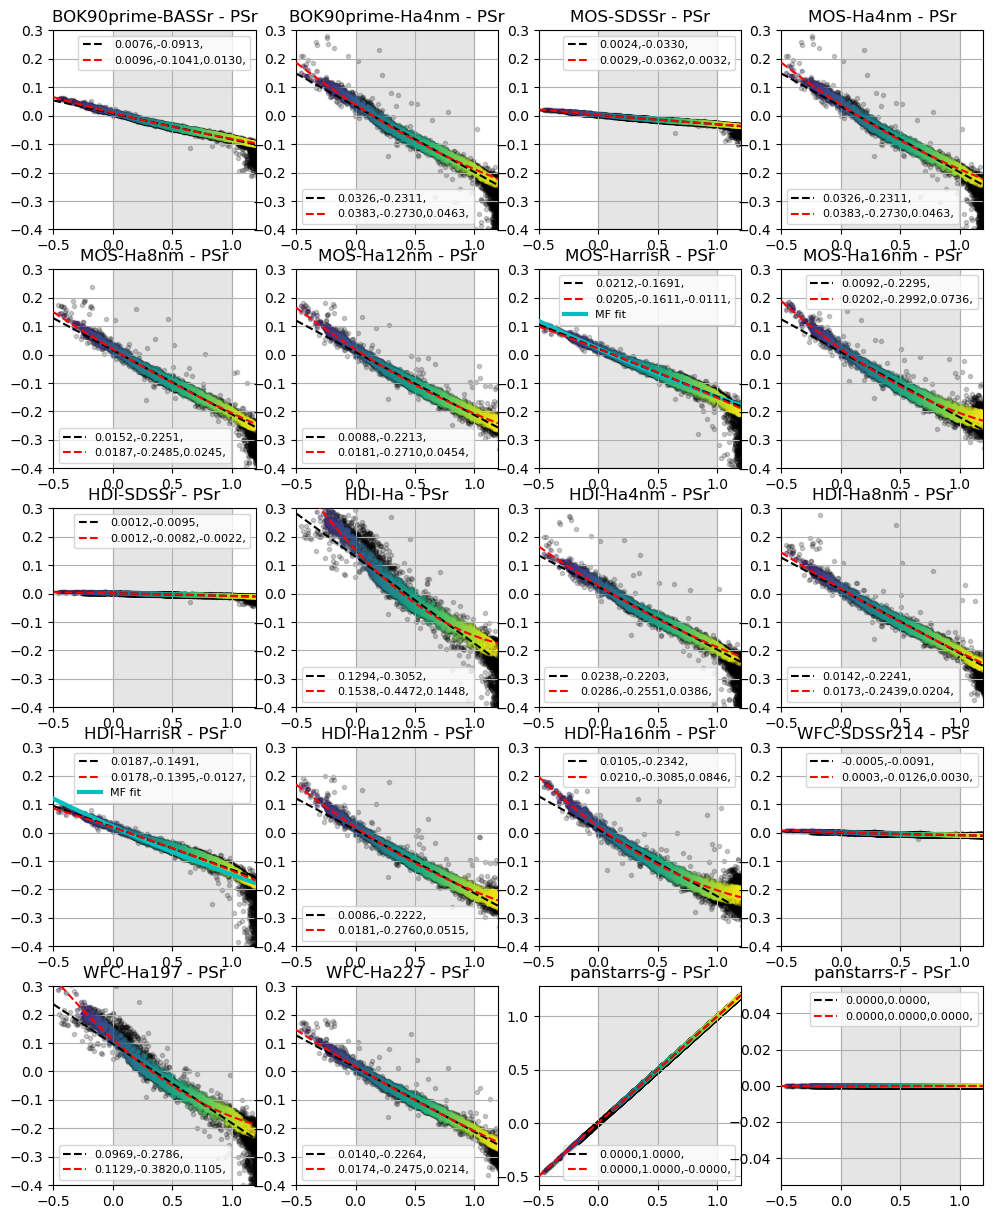

In [86]:
plt.figure(figsize=(12,15))
nplot = 1
nplot = 1
xmin = -.5
xmax = 1.2
ymax = 0.3
ymin = -0.4
mycolor = mastartab['panstarrs-g'] - mastartab['panstarrs-r']
for cname in mastartab.colnames:

    
    plt.subplot(5,4,nplot)
    dmag = mastartab[cname]-mastartab['panstarrs-r']

    # fit line
    fitflag = (mycolor < xmax) & (mycolor > xmin) & (~np.isnan(mycolor)) & (~np.isnan(dmag))

    #print('################################')
    #print(f"{cname} - PSr vs PSg-PSr")
    
    # fit line
    fitcolors = ['k','r']
    try:
        for npower in [1, 2]:
            fitted_poly, mask = polyfit_sigma_clipping(mycolor[fitflag],dmag[fitflag],degree=npower,niter=5)
            #fitted_poly, mask = polyfit_sigma_clipping(mycolor,dmag,npower)
            xline = np.linspace(xmin,xmax,100)
            s = ""
            for i in fitted_poly.parameters:
                s += f"{i:.4f}," 
            plt.plot(xline,fitted_poly(xline),'r--',color=fitcolors[npower-1],zorder=15,label=s)
            if npower == 2: # print out results for python dictionary
                print(f"'{cname}': ["+s+"]")

        
    except TypeError:
        print("Fitting failed for ", cname)
        mask = np.zeros(len(mycolor[fitflag]),'bool')
    if 'HarrisR' in cname:
        matteo_y = .0170*xline**2 + -0.1864*xline + 0.0213
        plt.plot(xline,matteo_y,'c-',label='MF fit',zorder=11,lw=3)
    plt.scatter(mycolor[fitflag][~mask], dmag[fitflag][~mask],c=mycolor[fitflag][~mask],s=5,vmin=xmin,vmax=xmax,zorder=10,alpha=0.2)

    plt.legend(fontsize=8)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    plt.plot(mycolor, dmag,'k.', alpha=0.2,zorder=1)
    plt.title(cname+' - PSr')
    plt.axis([x1,x2,y1,y2])
    #plt.axhline(ls='-', color='k')
    if ('panstarrs' not in cname):
        plt.ylim(ymin,ymax)
    plt.grid('True')
    plt.xlim(xmin,xmax)
    plt.gca().axvspan(0., 1., color='k', alpha=.1)
    
    nplot += 1

# How red are galaxies?  

Do we need to worry about the split in the data redward of $g-r > 1$

In [33]:
ephotfile = '/Users/rfinn/research/Virgo/tables-north/v2/vf_v2_legacy_ephot.fits'
ephot = Table.read(ephotfile)

In [34]:
ephot.colnames

['VFID',
 'photFlag',
 'SGA_ID',
 'VF_ID',
 'GALAXY',
 'X0_MOMENT',
 'Y0_MOMENT',
 'RA_MOMENT',
 'DEC_MOMENT',
 'SMA_MOMENT',
 'PA_MOMENT',
 'BA_MOMENT',
 'SMA_SB22',
 'SMA_SB22.5',
 'SMA_SB23',
 'SMA_SB23.5',
 'SMA_SB24',
 'SMA_SB24.5',
 'SMA_SB25',
 'SMA_SB25.5',
 'SMA_SB26',
 'SMA_IVAR_SB22',
 'SMA_IVAR_SB22.5',
 'SMA_IVAR_SB23',
 'SMA_IVAR_SB23.5',
 'SMA_IVAR_SB24',
 'SMA_IVAR_SB24.5',
 'SMA_IVAR_SB25',
 'SMA_IVAR_SB25.5',
 'SMA_IVAR_SB26',
 'FLUX_SB22_G',
 'FLUX_SB22.5_G',
 'FLUX_SB23_G',
 'FLUX_SB23.5_G',
 'FLUX_SB24_G',
 'FLUX_SB24.5_G',
 'FLUX_SB25_G',
 'FLUX_SB25.5_G',
 'FLUX_SB26_G',
 'FLUX_IVAR_SB22_G',
 'FLUX_IVAR_SB22.5_G',
 'FLUX_IVAR_SB23_G',
 'FLUX_IVAR_SB23.5_G',
 'FLUX_IVAR_SB24_G',
 'FLUX_IVAR_SB24.5_G',
 'FLUX_IVAR_SB25_G',
 'FLUX_IVAR_SB25.5_G',
 'FLUX_IVAR_SB26_G',
 'FRACMASKED_SB22_G',
 'FRACMASKED_SB22.5_G',
 'FRACMASKED_SB23_G',
 'FRACMASKED_SB23.5_G',
 'FRACMASKED_SB24_G',
 'FRACMASKED_SB24.5_G',
 'FRACMASKED_SB25_G',
 'FRACMASKED_SB25.5_G',
 'FRACMASKED_SB26_

In [52]:
g = 22.5 - 2.5*np.log10(ephot['FLUX_AP06_G'])

r = 22.5 - 2.5*np.log10(ephot['FLUX_AP06_R'])

gr = g - r

ptab = Table([r, gr], names=['r', 'g-r'])
df = ptab.to_pandas()

(-0.5, 1.5)

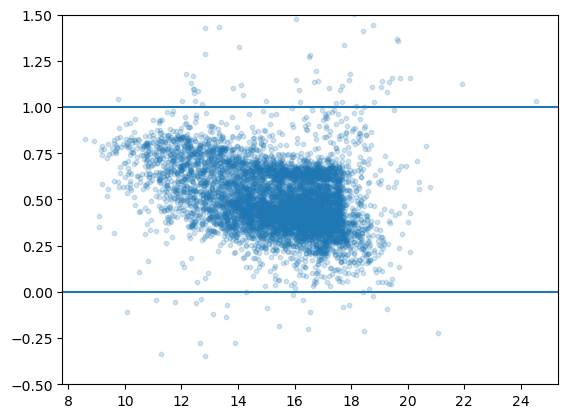

In [44]:
plt.figure()
plt.scatter(r,gr,s=10,alpha=.2)
plt.axhline(y=1)
plt.axhline(y=0)
plt.ylim(-.5,1.5)

In [50]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 3.3 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [seaborn]m1/2 [seaborn]


In [51]:
import seaborn as sns

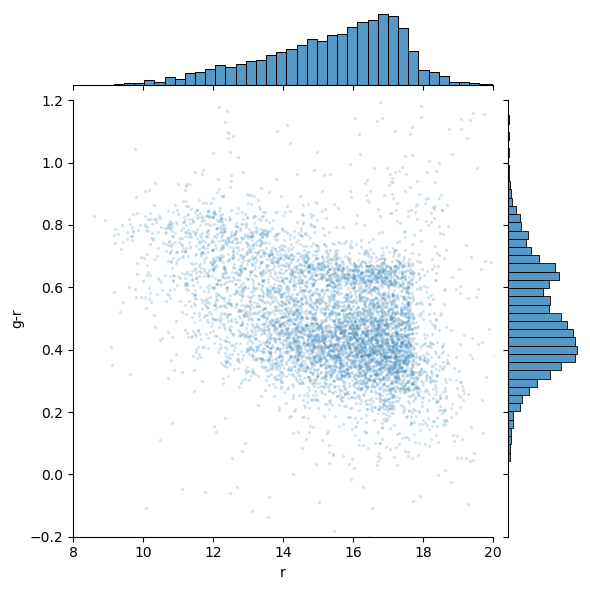

In [65]:
sns.jointplot(data=df, x="r", y="g-r", ylim=(-.2,1.2),xlim=(8,20),alpha=.2,s=5)


# Broad to NB color transformations

$HDI\_R - PSr = a0 + a1*(PSg-PSr) + a2*(PSg-PSr)^2 $

$HDI\_Ha4 - PSr = b0 + b1*(PSg-PSr) + b2*(PSg-PSr)^2 $

$HDI\_Ha4 - HDI\_R = (b0 - a0) + (b1 - a1)\times(PSg-PSr) + (b2-a2)\times(PSg-PSr)^2 $

## TODO

* fit the transformations for each NB filter to the corresponding r-band filter
* MOS: (r, R) to (ha4, ha8, ha12, ha16)
* HDI: (r, R) to (ha4, ha8, ha12, ha16)
* BOK: (r) to (ha4)
* WFC: (r) to (ha-197, ha-227)

In [67]:
mastartab.colnames

['BOK90prime-BASSr',
 'BOK90prime-Ha4nm',
 'MOS-SDSSr',
 'MOS-Ha4nm',
 'MOS-Ha8nm',
 'MOS-Ha12nm',
 'MOS-HarrisR',
 'MOS-Ha16nm',
 'HDI-SDSSr',
 'HDI-Ha',
 'HDI-Ha4nm',
 'HDI-Ha8nm',
 'HDI-HarrisR',
 'HDI-Ha12nm',
 'HDI-Ha16nm',
 'WFC-SDSSr214',
 'WFC-Ha197',
 'WFC-Ha227',
 'panstarrs-g',
 'panstarrs-r']

In [74]:
nbdict = {'BOK90prime-BASSr':['BOK90prime-Ha4nm'], 
          'MOS-SDSSr':['MOS-Ha4nm','MOS-Ha8nm','MOS-Ha12nm','MOS-Ha16nm'],
          'MOS-HarrisR':['MOS-Ha4nm','MOS-Ha8nm','MOS-Ha12nm','MOS-Ha16nm'],
          'HDI-SDSSr':['HDI-Ha4nm','HDI-Ha8nm','HDI-Ha12nm','HDI-Ha16nm'],
          'HDI-HarrisR':['HDI-Ha4nm','HDI-Ha8nm','HDI-Ha12nm','HDI-Ha16nm'],
          'WFC-SDSSr214':['WFC-Ha197','WFC-Ha227']}
print(nbdict.keys())

dict_keys(['BOK90prime-BASSr', 'MOS-SDSSr', 'MOS-HarrisR', 'HDI-SDSSr', 'HDI-HarrisR', 'WFC-SDSSr214'])


'BOK90prime-BASSr'
	'BOK90prime-Ha4nm': [0.0287,-0.1685,0.0329,]
'MOS-SDSSr'
	'MOS-Ha4nm': [0.0353,-0.2364,0.0430,]
	'MOS-Ha8nm': [0.0160,-0.2139,0.0236,]
	'MOS-Ha12nm': [0.0154,-0.2360,0.0435,]
	'MOS-Ha16nm': [0.0173,-0.2615,0.0683,]
'MOS-HarrisR'
	'MOS-Ha4nm': [0.0183,-0.1035,0.0407,]
	'MOS-Ha8nm': [-0.0010,-0.0925,0.0416,]
	'MOS-Ha12nm': [-0.0021,-0.1056,0.0478,]
	'MOS-Ha16nm': [-0.0005,-0.1218,0.0576,]
'HDI-SDSSr'
	'HDI-Ha4nm': [0.0274,-0.2470,0.0407,]
	'HDI-Ha8nm': [0.0161,-0.2355,0.0223,]
	'HDI-Ha12nm': [0.0168,-0.2664,0.0515,]
	'HDI-Ha16nm': [0.0197,-0.2979,0.0831,]
'HDI-HarrisR'
	'HDI-Ha4nm': [0.0107,-0.1039,0.0308,]
	'HDI-Ha8nm': [0.0003,-0.1108,0.0414,]
	'HDI-Ha12nm': [0.0004,-0.1306,0.0539,]
	'HDI-Ha16nm': [0.0030,-0.1519,0.0688,]
'WFC-SDSSr214'
	'WFC-Ha197': [0.1127,-0.3697,0.1077,]
	'WFC-Ha227': [0.0171,-0.2349,0.0184,]


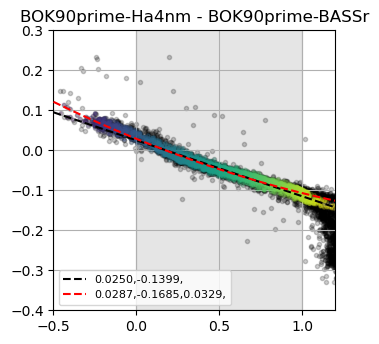

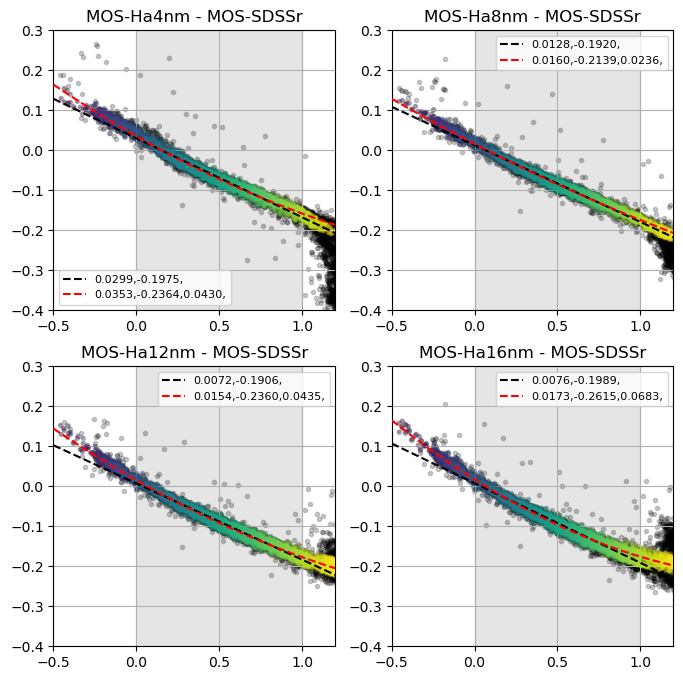

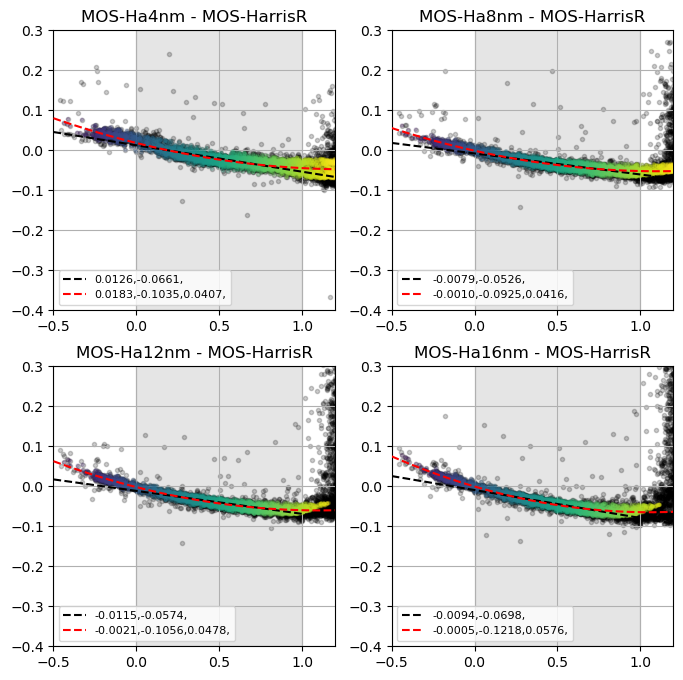

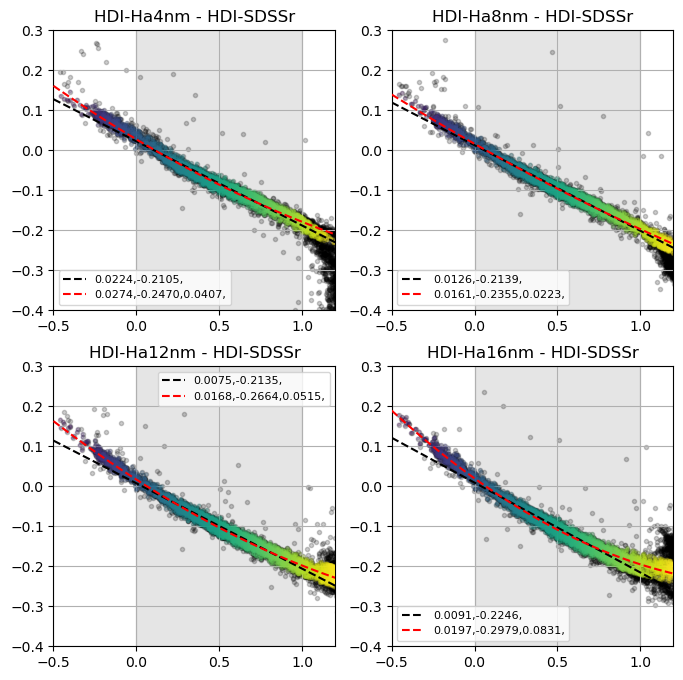

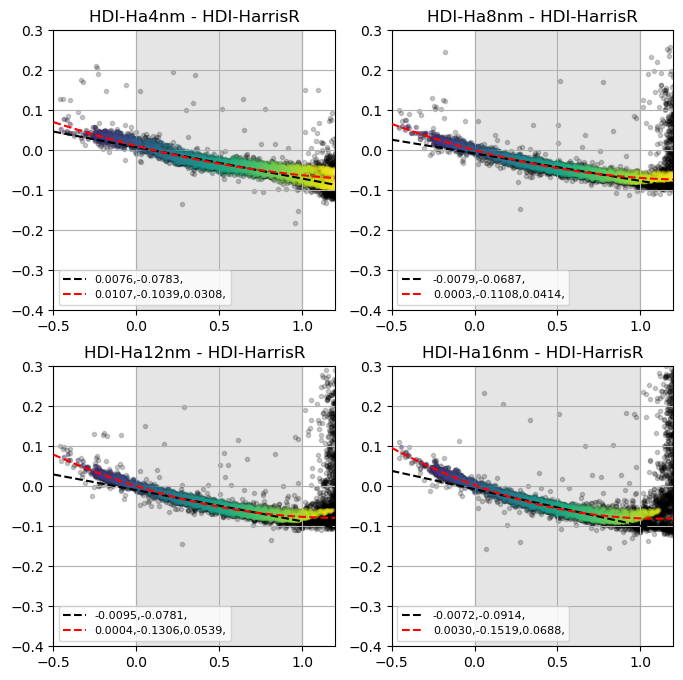

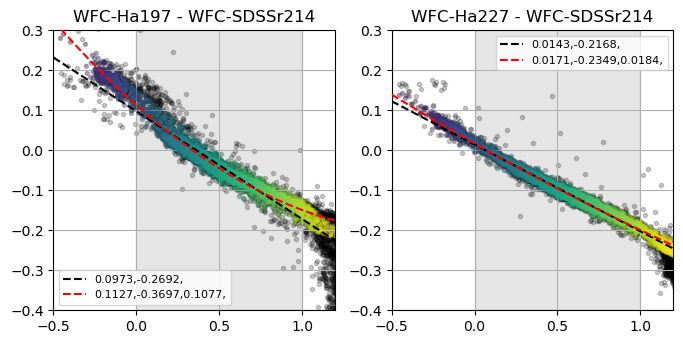

In [92]:
# fit the transformations for each NB filter to the corresponding r-band filter

#plt.figure(figsize=(12,15))


xmin = -.5
xmax = 1.2
ymax = 0.3
ymin = -0.4
mycolor = mastartab['panstarrs-g'] - mastartab['panstarrs-r']
for bbfilter in nbdict.keys():
    print(f"'{bbfilter}'")
    plt.figure(figsize=(8,8))
    nplot = 1
    for nbfilter in nbdict[bbfilter]:
        #print(nbfilter, nplot)
        plt.subplot(2,2,nplot)
        
        dmag = mastartab[nbfilter]-mastartab[bbfilter]
    
        # fit line
        fitflag = (mycolor < xmax) & (mycolor > xmin) & (~np.isnan(mycolor)) & (~np.isnan(dmag))
        
        
        # fit line
        fitcolors = ['k','r']
        try:
            for npower in [1, 2]:
                fitted_poly, mask = polyfit_sigma_clipping(mycolor[fitflag],dmag[fitflag],degree=npower,niter=5)
                #fitted_poly, mask = polyfit_sigma_clipping(mycolor,dmag,npower)
                xline = np.linspace(xmin,xmax,100)
                s = ""
                for i in fitted_poly.parameters:
                    s += f"{i:.4f}," 
                plt.plot(xline,fitted_poly(xline),'r--',color=fitcolors[npower-1],zorder=15,label=s)
                comment = ""
                #for i,cval in enumerate(c):
                #    comment += f"{cval:.4f}, "
                #plt.text(0.02,0.05*2*npower,comment, transform=plt.gca().transAxes)
                #print(f"\t{fitted_poly.parameters}")

                if npower == 2: # print out results for python dictionary
                    print(f"\t'{nbfilter}': ["+s+"]")

        except TypeError:
            print("Fitting failed for ", cname)
            mask = np.zeros(len(mycolor[fitflag]),'bool')
        
        plt.scatter(mycolor[fitflag][~mask], dmag[fitflag][~mask],c=mycolor[fitflag][~mask],s=5,vmin=xmin,vmax=xmax,zorder=10,alpha=0.2)
        plt.legend(fontsize=8)
        x1, x2 = plt.xlim()
        y1, y2 = plt.ylim()
        plt.plot(mycolor, dmag,'k.', alpha=0.2,zorder=1)
        plt.title(f"{nbfilter} - {bbfilter}")
        plt.axis([x1,x2,y1,y2])
        #plt.axhline(ls='-', color='k')
        if ('panstarrs' not in nbfilter):
            plt.ylim(ymin,ymax)
        plt.grid('True')
        plt.xlim(xmin,xmax)
        plt.gca().axvspan(0., 1., color='k', alpha=.1)
    
        nplot += 1